In [1]:
import utils
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data()

Now, we will normalize the data.

In [4]:
columns = [
    'target',
    'PRCP',
    'TMAX',
    'TMIN',
]
mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, columns, mean, std)
utils.preprocess(test, columns, mean, std)

In [5]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-03-03,-0.364319,-1.644261,-1.547583,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-01-17,-0.238134,-1.149823,-1.126503,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-06-06,0.115184,0.718051,0.678123,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2010-08-18,-0.364319,1.267426,1.399974,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2011-09-29,0.645160,0.553239,0.738277,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 441)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               56576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 64,897
Trainable params: 64,897
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3969 samples, validate on 993 samples
Epoch 1/50
3969/3969 [==============================] - 1s 372us/step - loss: 0.2464 - mean_absolute_error: 0.3589 - val_loss: 0.0972 - val_mean_absolute_error: 0.2311
Epoch 2/50
3969/3969 [==============================] - 1s 127us/step - loss: 0.1184 - mean_absolute_error: 0.2506 - val_loss: 0.0819 - val_mean_absolute_error: 0.2093
Epoch 3/50
3969/3969 [==============================] - 0s 124us/step - loss: 0.1020 - mean_absolute_error: 0.2315 - val_loss: 0.0788 - val_mean_absolute_error: 0.2134
Epoch 4/50
3969/3969 [==============================] - 0s 121us/step - loss: 0.0917 - mean_absolute_error: 0.2195 - val_loss: 0.0753 - val_mean_absolute_error: 0.2063
Epoch 5/50
3969/3969 [==============================] - 1s 131us/step - loss: 0.0841 - mean_absolute_error: 0.2115 - val_loss: 0.0840 - val_mean_absolute_error: 0.2244
Epoch 6/50
3969/3969 [==============================] - 0s 122us/step - loss: 0.0801 - mean_absolute_error: 0.204

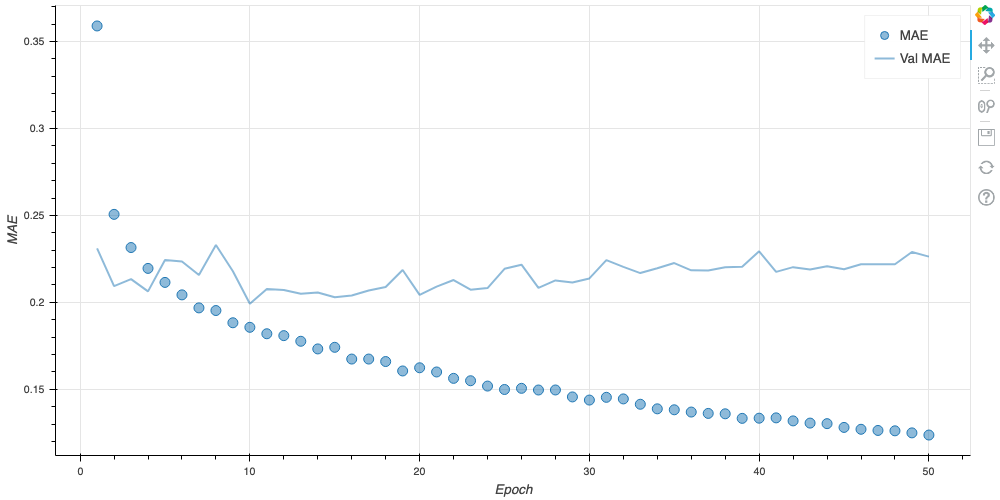

In [8]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

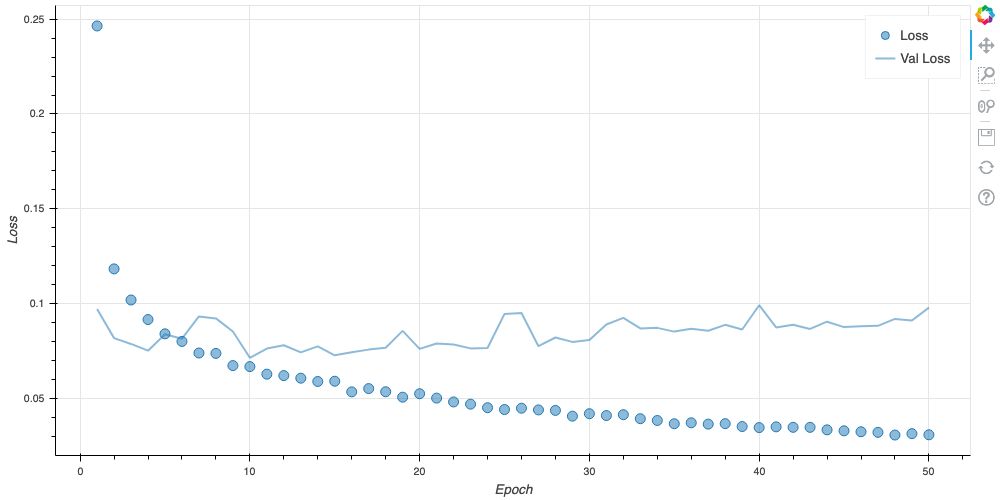

In [9]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

In [11]:
predictions = model.predict(test.copy().drop(columns=['target']))
results = test.copy()
results['prediction'] = predictions
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,prediction,date
2018-09-08,5953.126027,-0.313845,0.443364,0.738277,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5302.552734,2018-09-08
2016-10-04,5629.877740,-0.364319,0.333489,0.678123,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,6019.591797,2016-10-04
2005-06-18,5531.163946,-0.364319,0.718051,0.798431,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,5775.920898,2005-06-18
2015-08-27,6918.359459,-0.364319,1.047676,1.099202,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,7005.273926,2015-08-27
2018-10-29,5384.917708,-0.288608,-0.380698,-0.103882,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,5405.685547,2018-10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-07,5929.614189,0.443264,-2.028823,-1.728046,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5921.355469,2017-01-07
2012-12-03,5645.595862,-0.364319,-0.160948,0.016427,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5540.170898,2012-12-03
2006-02-15,5875.283333,-0.364319,-0.380698,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5711.819824,2006-02-15
2005-04-19,5610.283390,-0.364319,0.772989,0.076581,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5573.533691,2005-04-19


In [12]:
results = results.sort_index()
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,prediction,date
2005-03-04,5951.496552,-0.364319,-1.479448,-1.547583,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5990.674805,2005-03-04
2005-03-15,5885.332639,-0.364319,-0.930073,-1.246812,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5800.924805,2005-03-15
2005-03-16,5797.381724,-0.364319,-0.985011,-1.006195,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5877.423828,2005-03-16
2005-04-14,5507.621379,-0.364319,0.168676,-0.284344,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5483.147461,2005-04-14
2005-04-19,5610.283390,-0.364319,0.772989,0.076581,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5573.533691,2005-04-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,5395.633103,-0.364319,-1.534386,-1.427274,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5742.848145,2020-02-29
2020-03-07,5088.935069,-0.364319,-0.820198,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5212.569336,2020-03-07
2020-03-24,4818.006552,-0.364319,-0.435636,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5632.722168,2020-03-24
2020-03-25,4867.534828,-0.339082,-0.985011,-0.524961,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5573.757324,2020-03-25


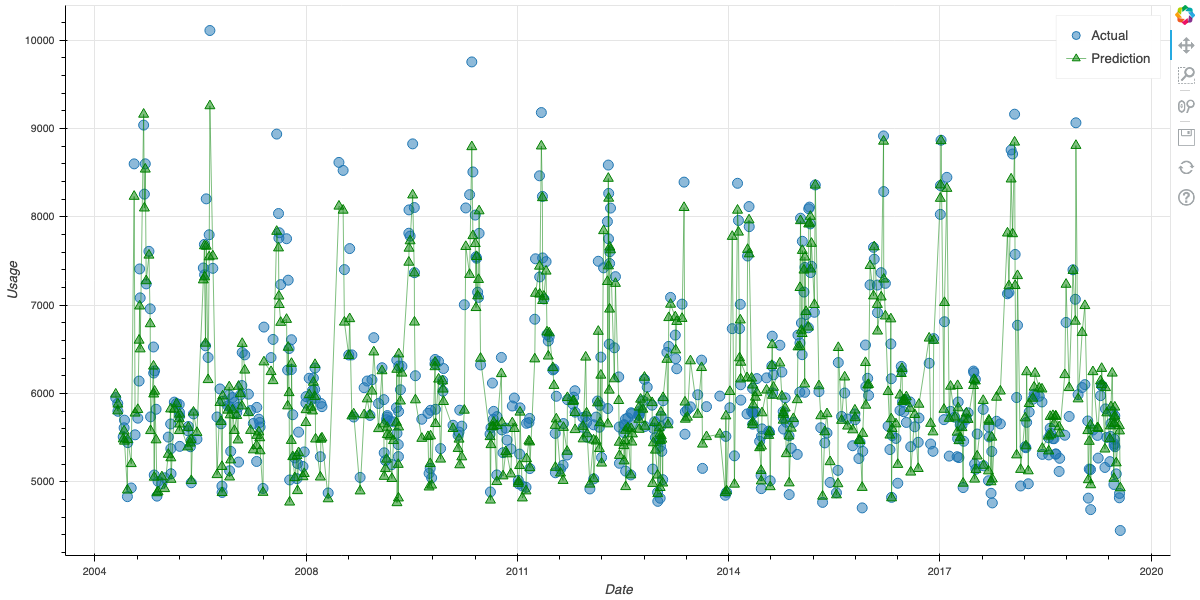

In [15]:
# results = ColumnDataSource(results)
pred_plot = figure(plot_width=1200, plot_height=600, x_axis_label='Date', y_axis_label='Usage')
pred_plot.circle(x='date', y='target', source=results, size=10, fill_alpha=.5, legend_label='Actual')
pred_plot.triangle(x='date', y='prediction', source=results, size=10, fill_alpha=.5, legend_label='Prediction', color='green')
pred_plot.line(x='date', y='prediction', source=results, alpha=.5, legend_label='Prediction', color='green')
pred_plot.xaxis.formatter=DatetimeTickFormatter()
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)